# <span style="color:#64943E">Vehicle Loan Prediction avec Fastai</span> 🚗🏦📊
## Essaie avec un minimum d'effort

**Problématique:**  

> A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date.

**Lien aux donées:**

https://www.kaggle.com/avikpaul4u/vehicle-loan-default-prediction

**Méthodologie "Experimental Setup"**

1. [x] Shuffle data (seed = 2019)
2. [x] Minimal Feature Engineering
4. [x] Under Sampling
5. [x] Cross-Validation
3. [x] Evaluation Metric of Choice: Accuracy

![image](https://user-images.githubusercontent.com/25487881/72540995-bf395980-384f-11ea-81c8-ecfe8f5cfcdd.png)

### 0. Import libraries and data

In [3]:
# Manipulation des données
import pandas as pd

# Préparation données
from sklearn.model_selection import train_test_split

# Fast ai - tabular models
from fastai import *
from fastai.tabular import *

In [4]:
data = pd.read_csv('train.csv'); data.head(20)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-91,Self employed,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


### 1. Shuffle data

In [73]:
#data = data.sample(frac=1, random_state=2019)

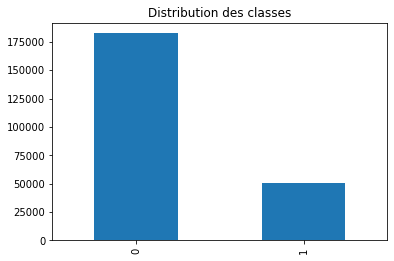

In [5]:
data['loan_default'].value_counts().plot.bar(title='Distribution des classes')

# Preprocessing à un minimum

1. [x] Enleve la colone de id
2. [x] Extrait le mois et l'annee du format *1yrs 11mon* pour la colone AVERAGE.ACCT.AGE et CREDIT.HISTORY.LENGTH
3. [x] Enleve les deux colones originale

In [6]:
data.drop('UniqueID', axis=1, inplace=True)  # Just unique values, no pattern

df_TEMP1 = data['AVERAGE.ACCT.AGE'].str.split('yrs|mon',expand=True)
data['AVERAGE.ACCT.AGE.YRS'] = df_TEMP1[0].astype(int)
data['AVERAGE.ACCT.AGE.MON'] = df_TEMP1[1].astype(int)
data.drop('AVERAGE.ACCT.AGE', axis = 1, inplace=True)

df_TEMP2 = data['CREDIT.HISTORY.LENGTH'].str.split('yrs|mon',expand=True)
data['CREDIT.HISTORY.YRS'] = df_TEMP2[0].astype(int)
data['CREDIT.HISTORY.MON'] = df_TEMP2[1].astype(int)
data.drop('CREDIT.HISTORY.LENGTH', axis = 1, inplace=True)

data.shape

(233154, 42)

# Undersampling à la paresseuse

In [7]:
sample_df_0 = data[data['loan_default']==0].iloc[50000:100000].copy()
sample_df_1 = data[data['loan_default']==1].iloc[:50000].copy()

sample_df_bal = sample_df_0.append(sample_df_1).reset_index(drop=True)

sample_df_bal = sample_df_bal.sample(frac=1)

sample_df_bal['loan_default'].value_counts()

1    50000
0    50000
Name: loan_default, dtype: int64

# FAST AI 😈😈

1. [x] Définir la variable dépendante (cible)
2. [x] Définir les variables continues
3. [x] Définir les variables catégoriques

In [8]:
dep_var = 'loan_default'

cont_names = ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE', 'PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT',
             'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT','SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
             'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','NO.OF_INQUIRIES',
             'CREDIT.HISTORY.YRS', 'CREDIT.HISTORY.MON','AVERAGE.ACCT.AGE.YRS','AVERAGE.ACCT.AGE.MON']

cat_names = [c_name for c_name in sample_df_bal.columns if c_name not in cont_names and c_name !='loan_default']

procs = [FillMissing, Categorify, Normalize]

# Stratified k-fold

In [9]:
from sklearn.model_selection import StratifiedKFold

In [10]:
skf = StratifiedKFold(n_splits=10)

acc_val = []
for train_idx, validation_idx in skf.split(sample_df_bal.index, sample_df_bal['loan_default']):
    
    # Create a data bunch
    data_fold = (TabularList.from_df(sample_df_bal, path='./', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(validation_idx)
                           .label_from_df(cols=dep_var)
                           .databunch())
    # Create a learner
    learner = tabular_learner(data_fold, layers=[500, 200], metrics=accuracy)
    
    # Fit using one cycle policy
    dump = learner.fit_one_cycle(1, 1e-2)
    
    # Store loss and accuracy values
    loss_fold, acc_fold = learner.validate()
    
    # Add Accuracy for that specific fold to a list
    acc_val.append(acc_fold)
    break

epoch,train_loss,valid_loss,accuracy,time
0,0.313882,0.315799,0.865100,00:27


In [71]:
np.mean(acc_val)

0.61643004

In [78]:
skf = StratifiedKFold(n_splits=10)

acc_val = []
for train_idx, validation_idx in skf.split(sample_df_bal.index, sample_df_bal['loan_default']):
    
    # Create a data bunch
    data_fold = (TabularList.from_df(sample_df_bal, path='./', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(validation_idx)
                           .label_from_df(cols=dep_var)
                           .databunch())
    # Create a learner
    learner = tabular_learner(data_fold, layers=[500, 200], metrics=accuracy)
    
    # Fit using one cycle policy
    dump = learner.fit_one_cycle(1, 1e-2)
    
    # Store loss and accuracy values
    loss_fold, acc_fold = learner.validate()
    
    # Add Accuracy for that specific fold to a list
    acc_val.append(acc_fold)

epoch,train_loss,valid_loss,accuracy,time
0,0.303872,0.307469,0.872600,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.303853,0.310289,0.868400,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.309818,0.304523,0.871700,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.317405,0.308172,0.870900,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.312809,0.302152,0.874600,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.317957,0.308139,0.869500,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.314086,0.312288,0.867500,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.305210,0.300587,0.873600,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.316470,0.306010,0.871500,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.310027,0.303968,0.872900,00:30


In [79]:
np.mean(acc_val)

0.87131995

In [8]:
skf = StratifiedKFold(n_splits=10)

acc_val = []
for train_idx, validation_idx in skf.split(sample_df_bal.index, sample_df_bal['loan_default']):
    
    # Create a data bunch
    data_fold = (TabularList.from_df(sample_df_bal, path='./', cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(validation_idx)
                           .label_from_df(cols=dep_var)
                           .databunch())
    # Create a learner
    learner = tabular_learner(data_fold, layers=[500, 200], metrics=accuracy)
    
    # Fit using one cycle policy
    dump = learner.fit_one_cycle(1, 1e-2)
    
    # Store loss and accuracy values
    loss_fold, acc_fold = learner.validate()
    
    # Add Accuracy for that specific fold to a list
    acc_val.append(acc_fold)

epoch,train_loss,valid_loss,accuracy,time
0,0.320662,0.318446,0.861100,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.320786,0.308941,0.868600,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.319446,0.313073,0.866800,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.328264,0.312525,0.865500,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.319277,0.327707,0.860300,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.314456,0.312263,0.867900,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.318605,0.312346,0.867200,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.311266,0.318037,0.863800,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.317620,0.317319,0.863100,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.323849,0.314900,0.865000,00:30
